In [ ]:
import os
from os import path
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from utilities.seq import aa_to_int_from_path
from utilities.tree import run_fitch, run_iqtree, get_depths
from utilities.utils import get_directory, parse_model_name, get_real_internals
from utilities.vae import load_model
from scripts.decode_recon_embeds import (
    get_profile_leaves,
    get_iqtree_ancseqs, 
    get_ardca_ancseqs,
    get_recon_ancseqs, 
    get_finch_ancseqs,
    get_prior_seqs
)
# mpl.rcParams.update({
#     #"text.usetex": True,               # Use LaTeX to render text
#     #"font.family": "serif",
#     #"font.serif": ["Computer Modern"], # Same font as LaTeX default
#     "axes.labelsize": 10,
#     "font.size": 10,
#     "legend.fontsize": 8,
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
# })

In [3]:
n_seqs = [1250, 5000, 10000] # number of sequences in each MSA
nl = 100 # Sequences of length 100 in each MSA
nc = 20 # Number of amino acids in the vocabulary (20 because there are no gaps in these simulated MSAs)
MSA_ids = [
    "COG28-l100-s1-a0.5",
    "COG2814-l100-s1-a0.5",
    "pevae"
    ]
rate_hets = [True, True, False]
fam_ids = [MSA_id.split("-")[0] for MSA_id in MSA_ids]
data_paths = [path.join(f"msas/independent/processed/{n_seq}", MSA_id) for MSA_id, n_seq in zip(MSA_ids, n_seqs)]
MSA_paths = [path.join(f"msas/independent/raw/{n_seq}", f"{MSA_id}.fa") for MSA_id, n_seq in zip(MSA_ids, n_seqs)] 
aa_idxs = [aa_to_int_from_path(data_path) for data_path in data_paths]
tree_paths = [f"trees/fast_trees/{n_seq}/{fam_id}.clean.tree" for fam_id, n_seq in zip(fam_ids, n_seqs)]

# Models
latent_dims = [2, 20, 20]
n_epochs = [500, 100, 500]
model_names = {}
for MSA_id, n_seq in zip(MSA_ids, n_seqs):
    if n_seq == 1250:
        wds = [0.005, 0.01, 0.01]
    else:
        wds = [0.001, 0.005, 0.005]
    model_names[MSA_id] = [f'ding_layers500_ld{ld}_wd{wd}_epoch{n_epoch}_2025-07-17.pt' for ld, n_epoch, wd in zip(latent_dims, n_epochs, wds)]

Get our reconstructions

In [4]:
recon_vae_dict = {}
for n_seq, MSA_id, data_path in zip(n_seqs, MSA_ids, data_paths):
    model_dir = get_directory(data_path, "saved_models")
    embeds_dir = get_directory(data_path, "embeddings", data_subfolder=True)
    recon_vae_dict[MSA_id] = {}
    for name in model_names[MSA_id]:
        # Load model
        is_trans, ld, num_hidden_units, dim_aa_embed, one_hot = parse_model_name(name)
        ding_model = name.startswith("ding")
        model_path = os.path.join(model_dir, name)
        model = load_model(model_path, nl=nl, nc=nc, ding_model=ding_model,
                            num_hidden_units=num_hidden_units, nlatent=ld,
                            one_hot=one_hot, dim_aa_embed=dim_aa_embed, trans=is_trans)
        # Read in embedding dataframe and retain only the columns that are embedding dimensions
        embeds_path = path.join(embeds_dir,
                               name.replace(".pt", "_anc-embeddings.csv"))
        embeds = pd.read_csv(embeds_path, index_col=0)
        embeds = embeds.loc[:, embeds.columns.str.startswith("dim")]
        # Save model data
        recon_vae_dict[MSA_id][name] = {
            "path": model_path,
            "model": model,
            "embeds": embeds,
            "recon_seqs": get_recon_ancseqs(model, embeds),
            "prior_seqs": get_prior_seqs(model, n_anc=len(embeds))
            }

anc_ids = {}
for MSA_id in MSA_ids:
    first_model = model_names[MSA_id][0]
    anc_ids[MSA_id] = recon_vae_dict[MSA_id][first_model]["embeds"].index.tolist()

Get modal sequence

In [7]:
mod_seq_dict = {}
for MSA_id, data_path in zip(MSA_ids, data_paths):
    mod_seq_dict[MSA_id] = get_profile_leaves(data_path, n_anc=len(embeds))

Get Fitch Reconstructions

In [9]:
recon_fitch_dict = {}
for aa_idx, MSA_id, data_path, tree_path in zip(aa_idxs, MSA_ids, data_paths, tree_paths):
    processed_msa_path = os.path.join(data_path, "seq_msa_char.fasta")
    _, seq_dict = run_fitch(processed_msa_path, tree_path)
    recon_fitch_dict[MSA_id] = get_finch_ancseqs(seq_dict, aa_idx, anc_ids[MSA_id])

Get IQTree Reconsructions

In [11]:
recon_iq_dict = {} 
for aa_index, MSA_id, data_path, tree_path in zip(aa_idxs, MSA_ids, data_paths, tree_paths):
    iqtree_dir = get_directory(data_path, "reconstructions/iqtree")
    os.makedirs(iqtree_dir, exist_ok=True)
    processed_msa_path = os.path.join(data_path, "seq_msa_char.fasta")
    run_iqtree(processed_msa_path, tree_path, iqtree_dir, redo=True)
    recon_iq_dict[MSA_id] = get_iqtree_ancseqs(iqtree_dir, aa_index, anc_ids[MSA_id])

Reconstructions for Node A1251 not found in IQTree output 
    because it is the root node in the cleaned tree, and for some reason, 
    IQTree does not reconstruct the sequence at the root node.
Reconstructions for Node A5001 not found in IQTree output 
    because it is the root node in the cleaned tree, and for some reason, 
    IQTree does not reconstruct the sequence at the root node.
Reconstructions for Node A10000 not found in IQTree output 
    because it is the root node in the cleaned tree, and for some reason, 
    IQTree does not reconstruct the sequence at the root node.


Get ArDCA Reconstructions

In [12]:
recon_ardca_dict = {}
for aa_index, MSA_id, data_path in zip(aa_idxs, MSA_ids, data_paths):
    ardca_dir = get_directory(data_path, "reconstructions/ardca")
    os.makedirs(iqtree_dir, exist_ok=True)
    recon_ardca_dict[MSA_id] = get_ardca_ancseqs(ardca_dir, aa_index, anc_ids[MSA_id])

Get real sequences

In [13]:
real_dict = {}
for aa_index, MSA_id, MSA_path in zip(aa_idxs, MSA_ids, MSA_paths):
    # no need to worry about dropped positions as these sequences have no gaps
    real_dict[MSA_id], _ = get_real_internals(MSA_path, aa_index, anc_ids[MSA_id], pos_preserved=None) 

Place reconstructed sequences under all methods in a single dictionary for acceptance by `plot_all_errror()`

In [14]:
all_est_seqs = {}
for MSA_id, data_path in zip(MSA_ids, data_paths):
    all_est_seqs[MSA_id] = {}
    all_est_seqs[MSA_id]["parsimony"] = recon_fitch_dict[MSA_id]
    all_est_seqs[MSA_id]["iqtree"] = recon_iq_dict[MSA_id]
    all_est_seqs[MSA_id]["ardca"] = recon_ardca_dict[MSA_id]
    all_est_seqs[MSA_id]["modal"] = mod_seq_dict[MSA_id]
    for name in model_names[MSA_id]:
        all_est_seqs[MSA_id][name] = recon_vae_dict[MSA_id][name]["recon_seqs"] 
        #all_est_seqs[MSA_id][f"{name}_prior"] = recon_vae_dict[MSA_id][name]["prior_seqs"]

Sanity check:

In [15]:
all_est_seqs[MSA_ids[0]].keys()

dict_keys(['parsimony', 'iqtree', 'ardca', 'modal', 'ding_layers500_ld2_wd0.005_epoch500_2025-07-17.pt', 'ding_layers500_ld20_wd0.01_epoch100_2025-07-17.pt', 'ding_layers500_ld20_wd0.01_epoch500_2025-07-17.pt'])

Get depths

In [ ]:
# Depths of the ancestral nodes
ordered_depths = {}
for MSA_id, tree_path in zip(MSA_ids, tree_paths):
    depths = get_depths(tree_path)
    ordered_depths[MSA_id] = [depths[id] for id in anc_ids[MSA_id]]

## Plot

First, aesthetics:

In [ ]:
lowess_smooth_frac = 0.3

# Aesthetics for baseline
baselines = [method for method in all_est_seqs[MSA_ids[0]].keys() if "model" and "ding" not in method] 
baseline_palette = sns.color_palette("colorblind", len(baselines))


# Aesthetics for models
#Keys are tuples (latent_dimension, num_epochs)
model_lstyles = {
    (2, 500): '--',
    (20, 100): '-.',
    (20, 500): ':'
}
model_labels = {(ld, n_epoch): f"VAE (latent dim={ld})" for ld, n_epoch in model_lstyles.keys()}
model_col = "purple"

fam_id_to_title = {
    "COG28": "1250 tips",
    "COG2814": "5000 tips",
    "pevae": "10000 tips"
}

width_in_inches = 3*len(MSA_ids)
height_in_inches = 2.5

Now create figure. Each panel has Hamming error versus depth curves for a different dataset and panels are placed next to each other.

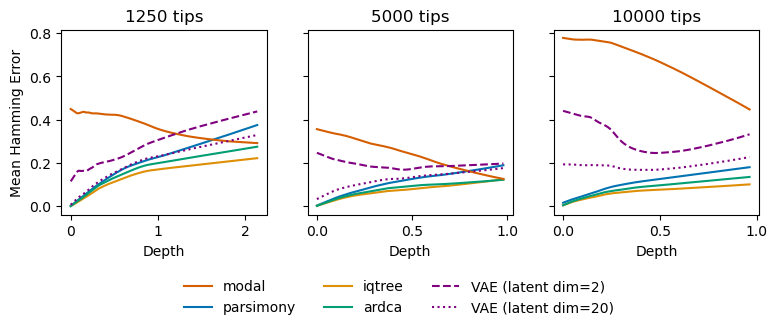

In [29]:
# Set up the figure
fig, axs = plt.subplots(1, len(MSA_ids), figsize=(width_in_inches, height_in_inches), sharey=True)
#fig.suptitle("Ancestral Reconstruction Hamming Error vs Depth in Tree", fontsize=16)
# fig.text(0.5, 0.9, 
#          "for various MSAs simulated with LG model", 
#          ha='center', fontsize=10)
axs[0].set_ylabel("Mean Hamming Error")

legend_models, legend_baselines = [], [] # handle for legend
# Plot the errors for each MSA
for ax, fam_id, MSA_id, rate_het in zip(axs, fam_ids, MSA_ids, rate_hets):
    
    # Preliminaries
    ax.set_title(fam_id_to_title[fam_id])
    ax.set_xlabel("Depth")
    est_seqs = all_est_seqs[MSA_id]
    real_seqs = real_dict[MSA_id]

    #Baseline approaches
    for baseline, color in zip(baselines, baseline_palette):
        # Compute the hamming error of the method
        ham_errors = []
        for (est_seq, real_seq) in zip(est_seqs[baseline], real_seqs):
            if all(est_seq == -1):  # handle missing reconstructions (iqtree)
                ham_errors.append(None)
                continue
            ham_errors.append(np.mean(est_seq != real_seq))
        # Add LOESS smooth
        valid_data = [(d, e) for d, e in zip(ordered_depths[MSA_id], ham_errors) if e is not None]
        if valid_data:
            valid_depths, valid_errors = zip(*valid_data)
            try:
                smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
                h, = ax.plot(smooth[:,0], smooth[:,1], color=color, label=baseline)
                if MSA_id == MSA_ids[0]: # only append to the legend once
                    legend_baselines.append(h)
            except Exception as e:
                print(f"Error while smoothing and plotting for {baseline}: {e}")
    
    # VAE-based approaches
    models = [method for method in all_est_seqs[MSA_id].keys() if "ding" in method]
    for model in models:
        
        #Initialize model aesthetics
        model_ld = int(re.search(r"ld(\d+)", model).group(1))
        model_nepoch = int(re.search(r"epoch(\d+)", model).group(1))
        model_lstyle = model_lstyles[(model_ld, model_nepoch)]
        model_label = model_labels[(model_ld, model_nepoch)]
        
        # don't plot 100 epoch models
        if model_nepoch == 100:
            continue

        # Get ASR errors
        ham_errors = []
        for (est_seq, real_seq) in zip(est_seqs[model], real_seqs):
            if all(est_seq == -1):  # handle missing reconstructions (iqtree)
                ham_errors.append(None)
                continue
            ham_errors.append(np.mean(est_seq != real_seq))

        # Estimate LOESS smooth to ASR errors and add to plot
        valid_data = [(d, e) for d, e in zip(ordered_depths[MSA_id], ham_errors) if e is not None]
        if valid_data:
            valid_depths, valid_errors = zip(*valid_data)
            try:
                smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
                h, = ax.plot(smooth[:,0], smooth[:,1], color=model_col, linestyle=model_lstyle, label=model_label)
                if MSA_id == MSA_ids[0]: # only append to the legend once
                    legend_models.append(h)
            except Exception as e:
                print(f"Error while smoothing and plotting for {baseline}: {e}")

# Combine baseline and model legends
# Ensure "modal" is first in the legend
combined_legend_handles = [legend_baselines[baselines.index("modal")]] + \
    [h for i, h in enumerate(legend_baselines) if baselines[i] != "modal"] + legend_models
combined_legend_labels = [h.get_label() for h in combined_legend_handles]

# Add a single legend to the figure
fig.legend(
    combined_legend_handles,
    combined_legend_labels,
    fontsize=10,
    frameon=False,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=len(combined_legend_handles) // 2
)
#fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("figures/ind_error-vs-depth.pdf", dpi=300, bbox_inches='tight')
